In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
pd.plotting.register_matplotlib_converters()
%matplotlib notebook

In [2]:
# Import GLODAP dataset as a standard pandas DataFrame
df = loadmat('datasets/GLODAPv2.2020_Atlantic_Ocean.mat')
df = {
    k[2:]: v.ravel()
    for k, v in df.items()
    if k.startswith('G2')
}
df = pd.DataFrame(df)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
df['datenum'] = mdates.date2num(df.datetime)

# Get tables of unique stations and cruises
stations = (
    df[['cruise', 'station', 'latitude', 'longitude', 'datetime', 'datenum']]
    .groupby(['cruise', 'station'])
    .agg('mean')
)
cruises = df.cruise.unique()
# ^a few interesting ones: cruises[[0, 30, **47**, 48, 50, 75, 100]]

# Also get GeoDataFrame
gstations = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude))

<IPython.core.display.Javascript object>


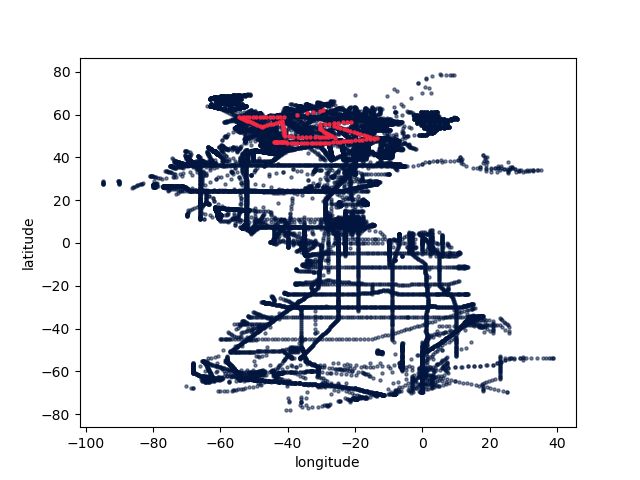

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

In [3]:
# Plot cruises, highlighting one of them
fig, ax = plt.subplots()
stations.plot.scatter('longitude', 'latitude', c='xkcd:navy', s=5, alpha=0.5, ax=ax)
stations.loc[cruises[47]].plot.scatter('longitude', 'latitude', s=5, alpha=0.9, c='xkcd:strawberry', ax=ax)

In [4]:
# Functions copied from Katy Abbott's Rule_based_segmentation.ipynb

def bearing(gdf):
    from numpy import sin, cos, arctan2
    #Take difference between i and i+1 rows, we get a deltalon column
    deltalon = gdf['longitude'].diff(1).shift(-1)
    #Move i+1 to ith row, now we have our lat2 column
    lat2 = gdf.shift(-1)['latitude'] 
    #Keep rows the same, this is our lat1 column
    lat1 = gdf['latitude']
    x0 = sin(deltalon)*cos(lat2)
    x1 = cos(lat1)*sin(lat2) - sin(lat1)*cos(lat2)*cos(deltalon)
    bearing = arctan2(x0, x1)
    return bearing


def iterative_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    trajectory_id = []
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    j = 0 #i.e., the first trajectory
    k = 0 #Keep track of iterations to identify the first row. This solves the problem where row indices don't start from 0
    for i, row in gdf.iterrows():
        #Assign starting value for the criterion
        if k == 0:
            start_value = row[criterion]
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                j+=1 #Start a new trajectory label
        start_value = row[criterion] #Update comparison value. This method is more robust to changes in curvature
        #that may not represent a new trajectory
        trajectory_id.append(j)
        k +=1
    gdf['traj_id'] = trajectory_id
    return gdf


def direction_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    trajectory_id = []
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    j = 0 #i.e., the first trajectory
    k = 0 #Keep track of iterations to identify the first row. This solves the problem where row indices don't start from 0
    for i, row in gdf.iterrows():
        #Assign starting value for the criterion
        if k == 0:
            start_value = row[criterion]
            k+=1
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                start_angle = row[criterion] #only change starting angle if we're starting a new trajectory
                j+=1 #Start a new trajectory label
         #Update 
        trajectory_id.append(j)
    gdf['traj_id'] = trajectory_id
    return gdf

/home/matthew/miniconda3/envs/OHW20/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<IPython.core.display.Javascript object>


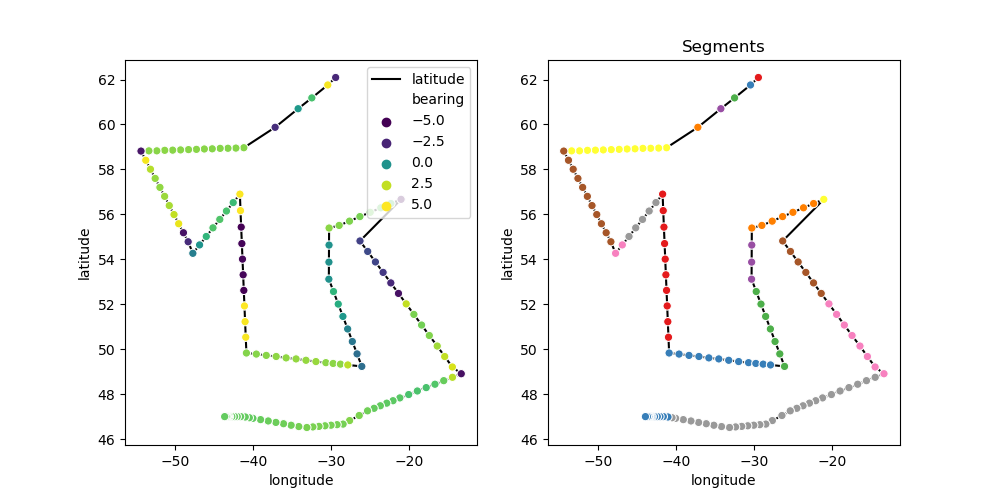

Text(0.5, 1.0, 'Segments')

In [9]:
# Just get the cruise of interest now as a GeoDataFrame
cruise_of_interest = cruises[47]
dataset = gstations.loc[cruise_of_interest]
dataset

# Apply segmentation
dataset['bearing'] = bearing(dataset)
dataset = iterative_segmentation(dataset, 'bearing', np.deg2rad(45))
dataset['traj_id'] = dataset['traj_id'].astype('category')  # improves plotting with Seaborn

# Plot bearing and segmentation
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
for ax in axs:
    ax.plot('longitude', 'latitude', data=dataset, c='k', zorder=0)
sns.scatterplot(x='longitude', y='latitude', hue='bearing', data=dataset, ax=axs[0], palette='viridis')
sns.scatterplot(x='longitude', y='latitude', hue='traj_id', data=dataset, ax=axs[1], palette='Set1', legend=False)
axs[1].set_title('Segments')